# Machine Learning Project 2 (Classification)
### Fraudulent Firm Classification

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import RidgeCV
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from  sklearn.preprocessing  import PolynomialFeatures
from sklearn import neighbors
from sklearn.svm import SVR

from sklearn import preprocessing

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, f1_score

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [4]:
import warnings
warnings.filterwarnings("ignore")

Reading the file contents in dataframes

In [7]:
audit_risk_df = pd.read_csv('./audit_risk.csv')
trial_df = pd.read_csv('./trial.csv')

In [8]:
#Keeping only the extra columns present in the trial file
trial_df = trial_df [['Marks','MONEY_Marks','Loss','LOSS_SCORE','History_score','Risk']]
#Renaming Risk column since a feature with same name is present in audit file
trial_df = trial_df.rename(columns={"Risk": "Risk_trial"})

Since the number of rows are same in both the files and joining on common features doesnt make sense we are concatenating both the data frames side by side.

#### There are many features in the dataset like Score_A, Score_B, etc.. which are repetetive and their values are also the same if we bring them to same scale. Since all the repetitive features have same values, we are keeping only 1 copy. Only "Risk" has different value in both files. 

In [9]:
result = pd.concat([audit_risk_df.reset_index(drop=True),trial_df.reset_index(drop=True)], axis=1)

In [10]:
result.columns

Index(['Sector_score', 'LOCATION_ID', 'PARA_A', 'Score_A', 'Risk_A', 'PARA_B',
       'Score_B', 'Risk_B', 'TOTAL', 'numbers', 'Score_B.1', 'Risk_C',
       'Money_Value', 'Score_MV', 'Risk_D', 'District_Loss', 'PROB', 'RiSk_E',
       'History', 'Prob', 'Risk_F', 'Score', 'Inherent_Risk', 'CONTROL_RISK',
       'Detection_Risk', 'Audit_Risk', 'Risk', 'Marks', 'MONEY_Marks', 'Loss',
       'LOSS_SCORE', 'History_score', 'Risk_trial'],
      dtype='object')

### Classification models from audit risk file 

In [11]:
#All three dependent variables
trial_risk_df = result['Risk_trial'].copy()
risk_df = result['Risk'].copy()
audit_risk_df = result['Audit_Risk'].copy()

In [12]:
#Independent variables - Dropping the Dependent Variables
features_df = result.drop(columns = ['Risk','Risk_trial','Audit_Risk'])

In [13]:
print (features_df[pd.to_numeric(features_df['LOCATION_ID'], errors='coerce').isnull()])

     Sector_score LOCATION_ID  PARA_A  Score_A  Risk_A  PARA_B  Score_B  \
351          1.99      LOHARU    0.30      0.2   0.060     0.0      0.2   
355          1.99         NUH    0.55      0.2   0.110     0.0      0.2   
367          1.99     SAFIDON    0.48      0.2   0.096     0.0      0.2   

     Risk_B  TOTAL  numbers      ...        Risk_F  Score  Inherent_Risk  \
351     0.0   0.30      5.0      ...           0.0    2.0          1.460   
355     0.0   0.55      5.0      ...           0.0    2.0          1.644   
367     0.0   0.48      5.0      ...           0.0    2.0          1.590   

     CONTROL_RISK  Detection_Risk  Marks  MONEY_Marks  Loss  LOSS_SCORE  \
351           0.4             0.5      2            2     0           2   
355           0.4             0.5      2            2     0           2   
367           0.4             0.5      2            2     0           2   

     History_score  
351              2  
355              2  
367              2  

[3 rows 

The feature LOCATION_ID has 3 non_numeric values 

In [14]:
features_df['LOCATION_ID'].unique()

array(['23', '6', '7', '8', '13', '37', '24', '3', '4', '14', '5', '20',
       '19', '21', '22', '9', '11', '12', '29', '30', '38', '31', '2',
       '32', '16', '33', '15', '36', '34', '18', '25', '39', '27', '35',
       '40', '41', '42', '1', '28', 'LOHARU', 'NUH', 'SAFIDON', '43',
       '44', '17'], dtype=object)

We will now replace the non-numeric values with unique numeric values

In [15]:
features_df.replace('LOHARU', '10', inplace = True)
features_df.replace('NUH', '26', inplace = True)
features_df.replace('SAFIDON', '45', inplace = True)
features_df['LOCATION_ID'] = features_df['LOCATION_ID'].astype(int)
features_df['LOCATION_ID'].unique()

array([23,  6,  7,  8, 13, 37, 24,  3,  4, 14,  5, 20, 19, 21, 22,  9, 11,
       12, 29, 30, 38, 31,  2, 32, 16, 33, 15, 36, 34, 18, 25, 39, 27, 35,
       40, 41, 42,  1, 28, 10, 26, 45, 43, 44, 17], dtype=int64)

Removing Location_ID from the feature set, since it is a nominal variable which will require 1 hot encoding resulting in 45 additional features.

In [16]:
features_df = features_df.drop(columns = ['LOCATION_ID'])

### Train Test Split

In [17]:
y = risk_df
X_train, X_test, y_train, y_test = train_test_split(features_df, y , test_size=0.30, random_state=42, stratify = y)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(543, 29) (543,)
(233, 29) (233,)


### Handling Missing values

In [18]:
X_train.columns[X_train.isna().any()].tolist()

[]

We see that there is no missing values in the training set.

In [19]:
X_test.columns[X_test.isna().any()].tolist()

['Money_Value']

We see that there is missing values in the testing set for the column Money_Value

In [20]:
missing_value_indices = X_test[X_test["Money_Value"].isnull()].index.values
len(missing_value_indices)

1

In [21]:
mean_X = X_train['Money_Value'].mean()

for ind in missing_value_indices:
    X_test.loc[ind,'Money_Value'] = mean_X

In [22]:
#No more missing values left in X_test
X_test.columns[X_test.isna().any()].tolist()

[]

### Correlation Analysis

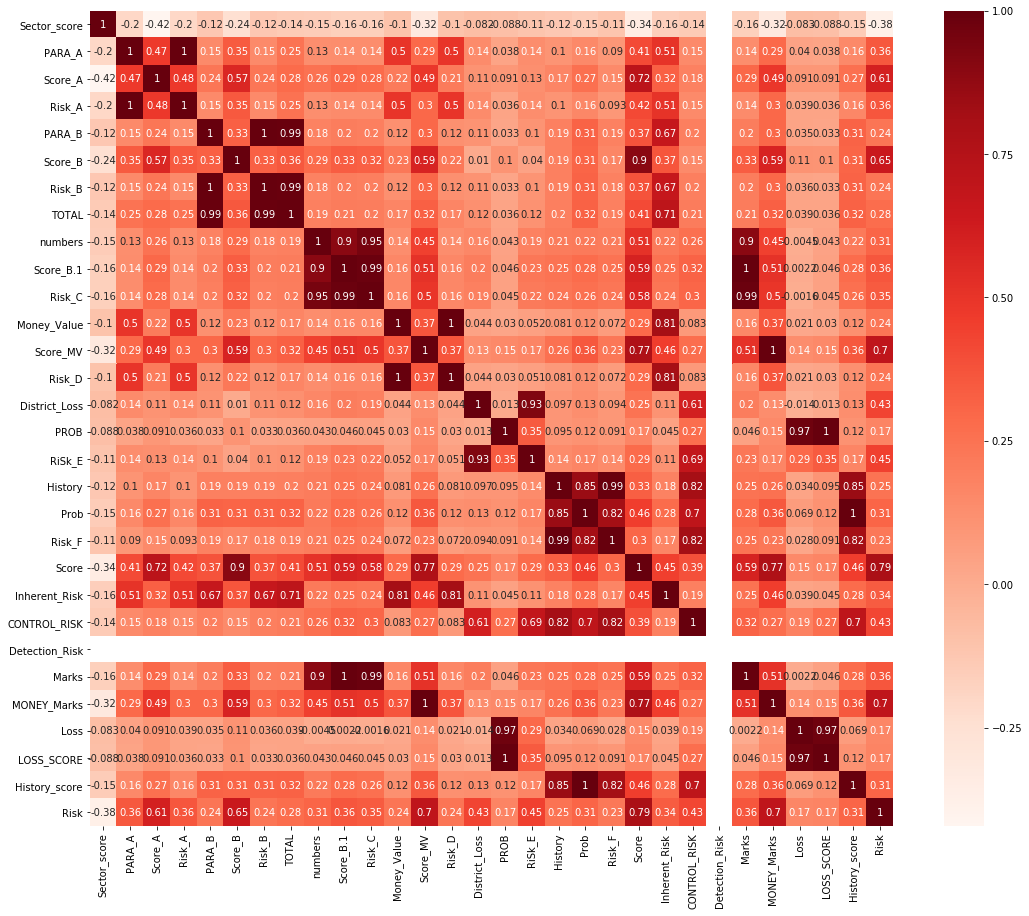

In [23]:
#Using Pearson Correlation
plt.figure(figsize=(18,15))
combined_train_df = pd.concat([X_train,y_train],axis=1)
cor = combined_train_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [25]:
X_train.columns

Index(['Sector_score', 'PARA_A', 'Score_A', 'Risk_A', 'PARA_B', 'Score_B',
       'Risk_B', 'TOTAL', 'numbers', 'Score_B.1', 'Risk_C', 'Money_Value',
       'Score_MV', 'Risk_D', 'District_Loss', 'PROB', 'RiSk_E', 'History',
       'Prob', 'Risk_F', 'Score', 'Inherent_Risk', 'CONTROL_RISK',
       'Detection_Risk', 'Marks', 'MONEY_Marks', 'Loss', 'LOSS_SCORE',
       'History_score'],
      dtype='object')

In [26]:
scaler = preprocessing.StandardScaler().fit(X_train)
#Means of All columns
print(scaler.mean_)
#StdDev of all columns
print(scaler.scale_)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

[20.22071823  2.58287403  0.34769797  1.43176081 11.82053278  0.31491713
  6.94027967 14.35810295  5.07550645  0.22541436  1.16593002 14.53573481
  0.29281768  8.5068081   2.51933702  0.20589319  0.51933702  0.1252302
  0.21915285  0.06629834  2.71307551 18.63684122  0.58563536  0.5
  2.25414365  2.9281768   0.02762431  2.05893186  2.19152855]
[2.42822521e+01 6.48255483e+00 1.73972238e-01 3.92091632e+00
 5.81096007e+01 1.70089194e-01 3.48891044e+01 5.94068115e+01
 2.92333709e-01 8.33161872e-02 5.66920708e-01 7.20516430e+01
 1.59891705e-01 4.32616990e+01 1.25669255e+00 3.79284439e-02
 2.81887094e-01 6.12160901e-01 7.43394523e-02 3.56815410e-01
 8.76937123e-01 6.08788669e+01 4.84925534e-01 1.00000000e+00
 8.33161872e-01 1.59891705e+00 1.85007269e-01 3.79284439e-01
 7.43394523e-01]


In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components= 0.95).fit(X_train)

In [28]:
pca.n_components_

10

In [29]:
pca.explained_variance_ratio_

array([0.31997794, 0.12968944, 0.11110155, 0.10669359, 0.08466047,
       0.06982485, 0.05801255, 0.03934929, 0.029929  , 0.01944712])

In [30]:
pca = PCA(n_components=10).fit(X_train)
X_reduce_train = pca.transform(X_train)

pca = PCA(n_components=10).fit(X_test)
X_reduce_test = pca.transform(X_test)

### Data Scaling

### Since all the columns are nearly in the same scale we can standardize the data so that our data follows a standard normal distribution, which provides better results once they go through the ML algorithms

In [31]:
scaler = preprocessing.StandardScaler().fit(X_reduce_train)
#Means of All columns
print(scaler.mean_)
#StdDev of all columns
print(scaler.scale_)
X_train = scaler.transform(X_reduce_train)
X_test  = scaler.transform(X_reduce_test)

[ 1.01821559e-16  2.70910775e-17  2.39730478e-17  1.99605014e-17
 -1.68680294e-17  2.03438657e-17 -2.04460962e-19 -2.28996278e-17
 -2.61710032e-17  5.82713742e-17]
[2.99322275 1.90559814 1.76375832 1.7284156  1.53964061 1.39824744
 1.27450048 1.04965708 0.91542989 0.73791554]


## Classification Stategy

Since our use case is fraud detection, accuracy is not such an import measure in comparision to recall.

### Assuming our ConfusionMatrix is like this, where posistive class represents Fraud

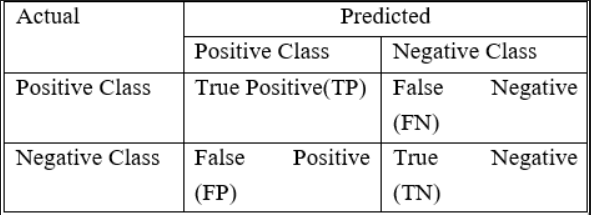

### Here, the important metric is Recall which is (TP)/(TP+FN)
Since this captures that out of the total frauds, how many of those frauds were we able to catch.

### We can also use F1 Score for evaluating the models, since it gives a good balance between precision and recall

### KNN Classifier - CV =5, Voting classifier (hard & soft)

In [32]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1,20)}

knn_gs = GridSearchCV(knn, param_grid, cv=5, scoring='recall')
knn_gs.fit(X_train, y_train)

print(knn_gs.best_params_)
print(knn_gs.best_score_)

{'n_neighbors': 1}
0.9297736825682348


In [33]:
y_pred = knn_gs.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Accuracy',accuracy_score(y_test, y_pred))
print('Recall',recall_score(y_test, y_pred))
print('F1 Score',f1_score(y_test, y_pred))

[[134   7]
 [ 34  58]]
             precision    recall  f1-score   support

          0       0.80      0.95      0.87       141
          1       0.89      0.63      0.74        92

avg / total       0.84      0.82      0.82       233

Accuracy 0.8240343347639485
Recall 0.6304347826086957
F1 Score 0.7388535031847134


### Soft Voting on KNN Classifier

In [35]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('knn', knn_gs)], voting='soft')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
for clf in (voting_clf, ):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

VotingClassifier 0.8240343347639485


### Hard Voting on KNN Classifier

In [36]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('knn', knn_gs)], voting='hard')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
for clf in (voting_clf, ):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

VotingClassifier 0.8240343347639485


### SVM - CV = 5; Voting Classifier

In [37]:
from sklearn.svm import SVC

svm_clf = SVC(C = 10, probability = True)
svm_clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Soft Voting on SVM Classifier

In [38]:
voting_clf = VotingClassifier(estimators=[('svc', svm_clf)], voting='soft')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
for clf in (svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

SVC 0.8755364806866953
VotingClassifier 0.8969957081545065


### Hard Voting on SVM Classifier

In [39]:
voting_clf = VotingClassifier(estimators=[('svc', svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
for clf in (svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

SVC 0.8755364806866953
VotingClassifier 0.8755364806866953


In [40]:
sns.set(rc={'figure.figsize':(20,12)})

## Bagging

### Bagging with Decision tree

Text(0,0.5,'Scores')

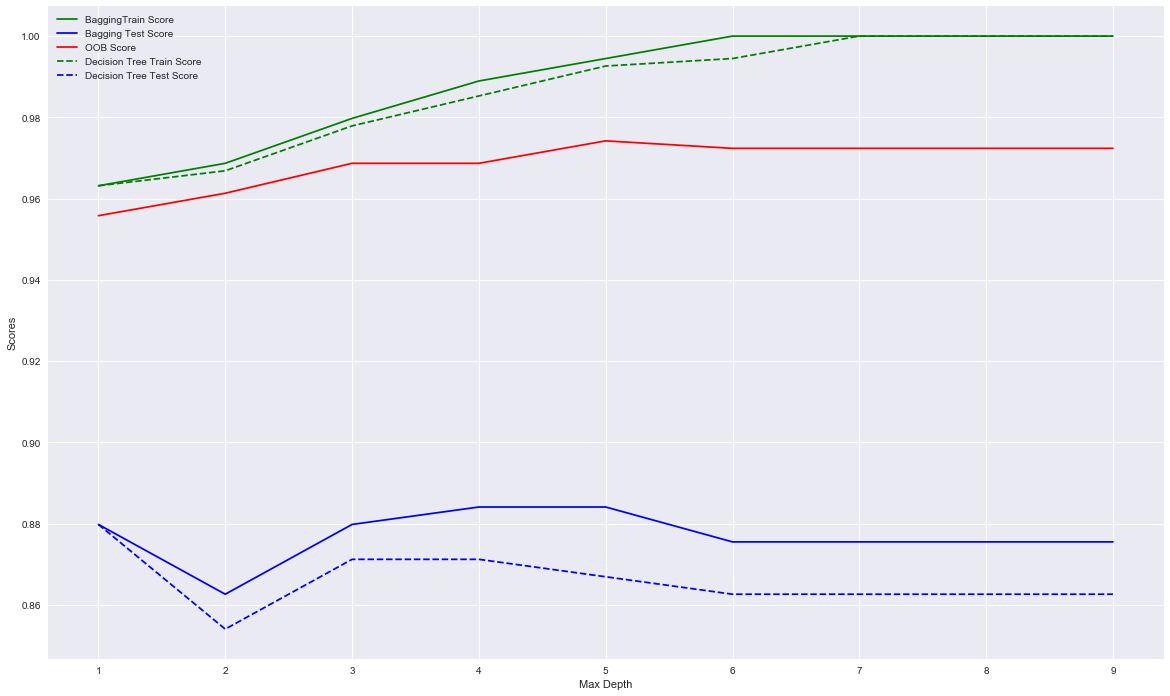

In [41]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

org_train_score_array = []
org_test_score_array = []
train_score_array = []
test_score_array = []
oob_score_array=[]

for n in range(1,10):
    dt_clf = DecisionTreeClassifier(max_depth=n,random_state=0)
    dt_clf.fit(X_train, y_train)
    org_train_score_array.append(dt_clf.score(X_train, y_train))
    org_test_score_array.append(dt_clf.score(X_test, y_test))
    bag_clf_dt = BaggingClassifier(dt_clf, n_estimators=500, max_samples=500, bootstrap=True,random_state=0,oob_score=True)
    bag_clf_dt.fit(X_train, y_train)
    train_score_array.append(bag_clf_dt.score(X_train, y_train))
    test_score_array.append(bag_clf_dt.score(X_test, y_test))
    oob_score_array.append(bag_clf_dt.oob_score_)

x_axis = range(1,10)
plt.plot(x_axis, train_score_array, c = 'g', label = 'BaggingTrain Score')
plt.plot(x_axis, test_score_array, c = 'b', label = 'Bagging Test Score')
plt.plot(x_axis, oob_score_array, c = 'r', label = 'OOB Score')
plt.plot(x_axis, org_train_score_array, c = 'g', label = 'Decision Tree Train Score', linestyle = '--')
plt.plot(x_axis, org_test_score_array, c = 'b', label = 'Decision Tree Test Score', linestyle = '--')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Scores')

In [42]:
dt_clf = DecisionTreeClassifier(max_depth=7,random_state=0)
dt_clf.fit(X_train, y_train)

bag_clf_dt = BaggingClassifier(dt_clf, n_estimators=500, max_samples=500, bootstrap=False,random_state=0)
bag_clf_dt.fit(X_train, y_train)

y_pred=bag_clf_dt.predict(X_test)

print('Train score: {:.4f}'.format(bag_clf_dt.score(X_train, y_train)))
print('Test score: {:.4f}'.format(bag_clf_dt.score(X_test, y_test)))
from sklearn.metrics import accuracy_score
print('Accuracy Score: {:.4f}'.format(accuracy_score(y_test,y_pred)))

Train score: 1.0000
Test score: 0.8627
Accuracy Score: 0.8627


### Bagging with KNN

Text(0,0.5,'Scores')

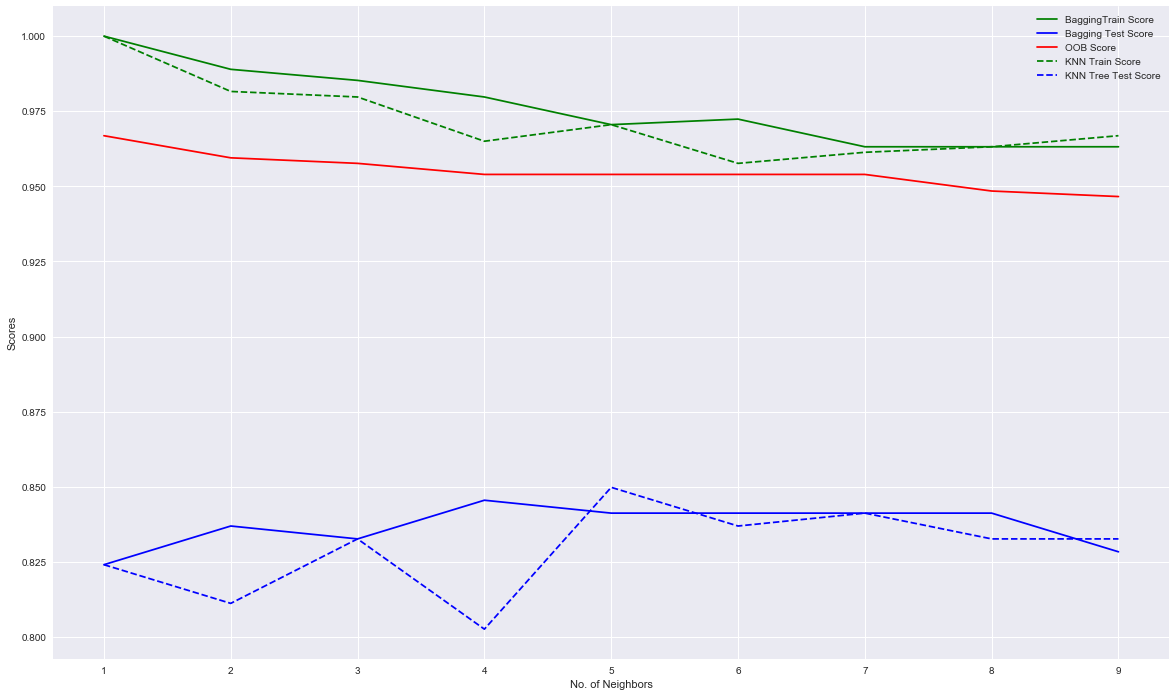

In [43]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

org_train_score_array = []
org_test_score_array = []
train_score_array = []
test_score_array = []
oob_score_array=[]

for n in range(1,10):
    knn_clf = KNeighborsClassifier(n_neighbors=n)
    knn_clf.fit(X_train, y_train)
    org_train_score_array.append(knn_clf.score(X_train, y_train))
    org_test_score_array.append(knn_clf.score(X_test, y_test))
    bag_clf_knn = BaggingClassifier(knn_clf, n_estimators=500, max_samples=500, bootstrap=True,random_state=0,oob_score=True)
    bag_clf_knn.fit(X_train, y_train)
    train_score_array.append(bag_clf_knn.score(X_train, y_train))
    test_score_array.append(bag_clf_knn.score(X_test, y_test))
    oob_score_array.append(bag_clf_knn.oob_score_)

x_axis = range(1,10)
plt.plot(x_axis, train_score_array, c = 'g', label = 'BaggingTrain Score')
plt.plot(x_axis, test_score_array, c = 'b', label = 'Bagging Test Score')
plt.plot(x_axis, oob_score_array, c = 'r', label = 'OOB Score')
plt.plot(x_axis, org_train_score_array, c = 'g', label = 'KNN Train Score', linestyle = '--')
plt.plot(x_axis, org_test_score_array, c = 'b', label = 'KNN Tree Test Score', linestyle = '--')
plt.legend()
plt.xlabel('No. of Neighbors')
plt.ylabel('Scores')

In [44]:
knn_clf = KNeighborsClassifier(n_neighbors=4)
knn_clf.fit(X_train, y_train)

bag_clf_knn = BaggingClassifier(knn_clf, n_estimators=500, max_samples=500, bootstrap=False,random_state=0)
bag_clf_knn.fit(X_train, y_train)

y_pred=bag_clf_knn.predict(X_test)

print('Train score: {:.4f}'.format(bag_clf_knn.score(X_train, y_train)))
print('Test score: {:.4f}'.format(bag_clf_knn.score(X_test, y_test)))
print('Accuracy Score: {:.4f}'.format(accuracy_score(y_test,y_pred)))

Train score: 0.9705
Test score: 0.8498
Accuracy Score: 0.8498


## Pasting

### Pasting with Decision Tree

Text(0,0.5,'Scores')

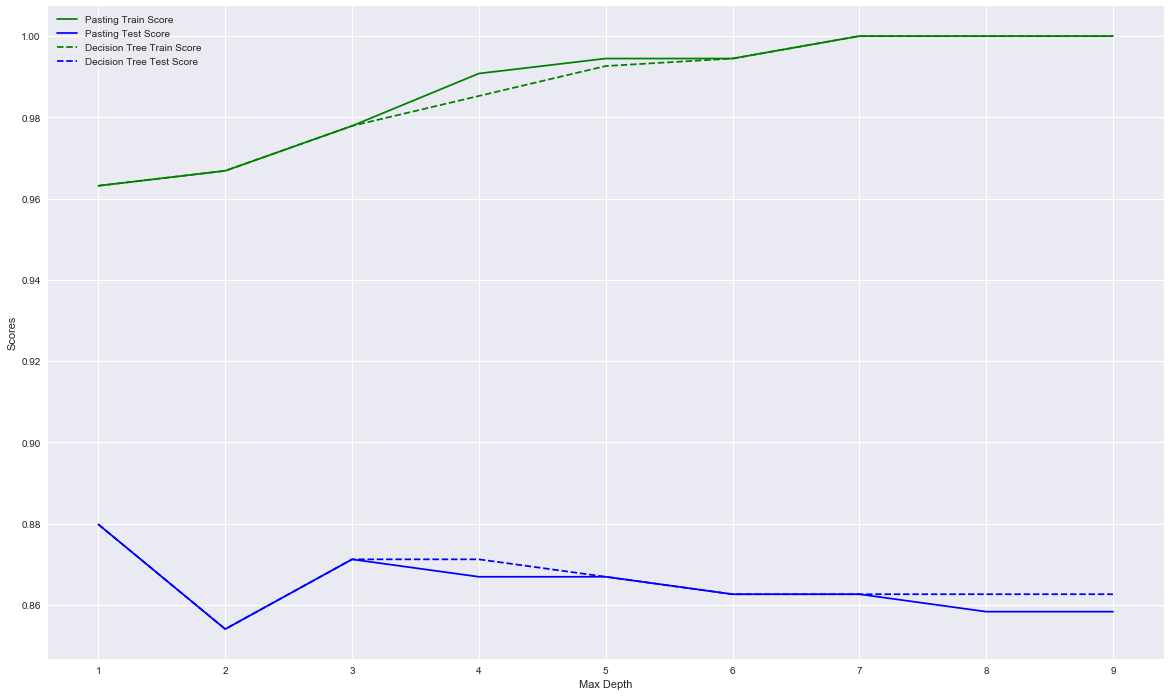

In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

org_train_score_array = []
org_test_score_array = []
train_score_array = []
test_score_array = []

for n in range(1,10):
    dt_clf = DecisionTreeClassifier(max_depth=n,random_state=0)
    dt_clf.fit(X_train, y_train)
    org_train_score_array.append(dt_clf.score(X_train, y_train))
    org_test_score_array.append(dt_clf.score(X_test, y_test))
    paste_clf_dt = BaggingClassifier(dt_clf, n_estimators=500, max_samples=500, bootstrap=False,random_state=0)
    paste_clf_dt.fit(X_train, y_train)
    train_score_array.append(paste_clf_dt.score(X_train, y_train))
    test_score_array.append(paste_clf_dt.score(X_test, y_test))

x_axis = range(1,10)
plt.plot(x_axis, train_score_array, c = 'g', label = 'Pasting Train Score')
plt.plot(x_axis, test_score_array, c = 'b', label = 'Pasting Test Score')
plt.plot(x_axis, org_train_score_array, c = 'g', label = 'Decision Tree Train Score', linestyle = '--')
plt.plot(x_axis, org_test_score_array, c = 'b', label = 'Decision Tree Test Score', linestyle = '--')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Scores')

In [48]:
dt_clf = DecisionTreeClassifier(max_depth=9,random_state=0)
dt_clf.fit(X_train, y_train)

paste_clf_dt = BaggingClassifier(dt_clf, n_estimators=500, max_samples=500, bootstrap=False,random_state=0)
paste_clf_dt.fit(X_train, y_train)

y_pred=paste_clf_dt.predict(X_test)

print('Train score: {:.4f}'.format(paste_clf_dt.score(X_train, y_train)))
print('Test score: {:.4f}'.format(paste_clf_dt.score(X_test, y_test)))

print('Accuracy Score: {:.4f}'.format(accuracy_score(y_test,y_pred)))

Train score: 1.0000
Test score: 0.8584
Accuracy Score: 0.8584


### Pasting with KNN

Text(0,0.5,'Scores')

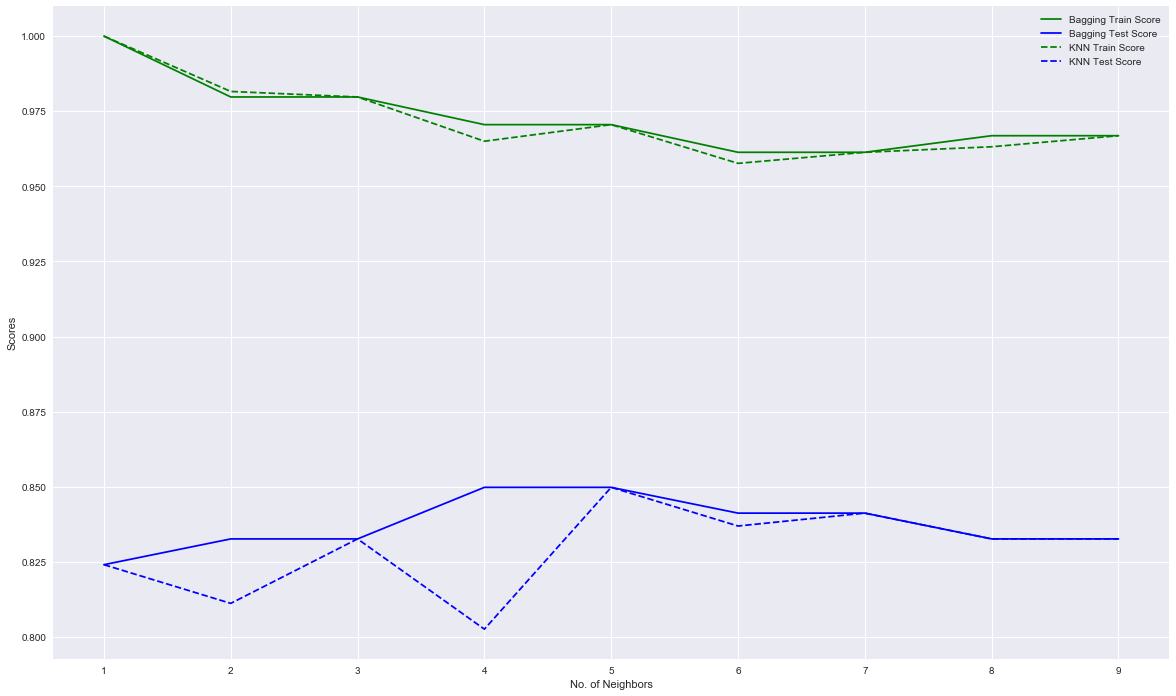

In [49]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

org_train_score_array = []
org_test_score_array = []
train_score_array = []
test_score_array = []

for n in range(1,10):
    knn_clf = KNeighborsClassifier(n_neighbors=n)
    knn_clf.fit(X_train, y_train)
    org_train_score_array.append(knn_clf.score(X_train, y_train))
    org_test_score_array.append(knn_clf.score(X_test, y_test))
    paste_clf_knn = BaggingClassifier(knn_clf, n_estimators=500, max_samples=500, bootstrap=False,random_state=0)
    paste_clf_knn.fit(X_train, y_train)
    train_score_array.append(paste_clf_knn.score(X_train, y_train))
    test_score_array.append(paste_clf_knn.score(X_test, y_test))

x_axis = range(1,10)
plt.plot(x_axis, train_score_array, c = 'g', label = 'Bagging Train Score')
plt.plot(x_axis, test_score_array, c = 'b', label = 'Bagging Test Score')
plt.plot(x_axis, org_train_score_array, c = 'g', label = 'KNN Train Score', linestyle = '--')
plt.plot(x_axis, org_test_score_array, c = 'b', label = 'KNN Test Score', linestyle = '--')
plt.legend()
plt.xlabel('No. of Neighbors')
plt.ylabel('Scores')

In [50]:
knn_clf = KNeighborsClassifier(n_neighbors=4)
knn_clf.fit(X_train, y_train)

paste_clf_knn = BaggingClassifier(knn_clf, n_estimators=500, max_samples=500, bootstrap=False,random_state=0)
paste_clf_knn.fit(X_train, y_train)

y_pred=paste_clf_knn.predict(X_test)

print('Train score: {:.4f}'.format(paste_clf_knn.score(X_train, y_train)))
print('Test score: {:.4f}'.format(paste_clf_knn.score(X_test, y_test)))
print('Accuracy Score: {:.4f}'.format(accuracy_score(y_test,y_pred)))

Train score: 0.9705
Test score: 0.8498
Accuracy Score: 0.8498


### Adaboosting on Decision Tree

In [43]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5, random_state=0)
#Change the n_estimators and learning_rate and check the plot if the decision boundary improves
ada_clf.fit(X_reduce_train, y_train)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=0)

In [44]:
print("Accuracy on training set: {:.3f}".format(ada_clf.score(X_reduce_train, y_train)))
print("Accuracy on test set: {:.3f}".format(ada_clf.score(X_reduce_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.876


### Adaboosting on SVM

In [45]:
from sklearn.ensemble import AdaBoostClassifier

from sklearn.svm import SVC

from sklearn import metrics
svc=SVC(probability=True, kernel='linear')

abc =AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)

model = abc.fit(X_reduce_train, y_train)
y_pred = model.predict(X_reduce_test)

In [46]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.871244635193133


### Gradient Boosting

In [47]:
from  sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_reduce_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_reduce_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_reduce_test, y_test)))

Accuracy on training set: 0.976
Accuracy on test set: 0.923


## Project 1 models with PCA

### KNN Classifier

In [51]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1,20)}

knn_gs = GridSearchCV(knn, param_grid, cv=5, scoring='recall')
knn_gs.fit(X_reduce_train, y_train)

print(knn_gs.best_params_)
print(knn_gs.best_score_)

{'n_neighbors': 1}
0.9297736825682348


[[136   5]
 [ 25  67]]
             precision    recall  f1-score   support

          0       0.84      0.96      0.90       141
          1       0.93      0.73      0.82        92

avg / total       0.88      0.87      0.87       233

Accuracy 0.871244635193133
Recall 0.7282608695652174
F1 Score 0.8170731707317073


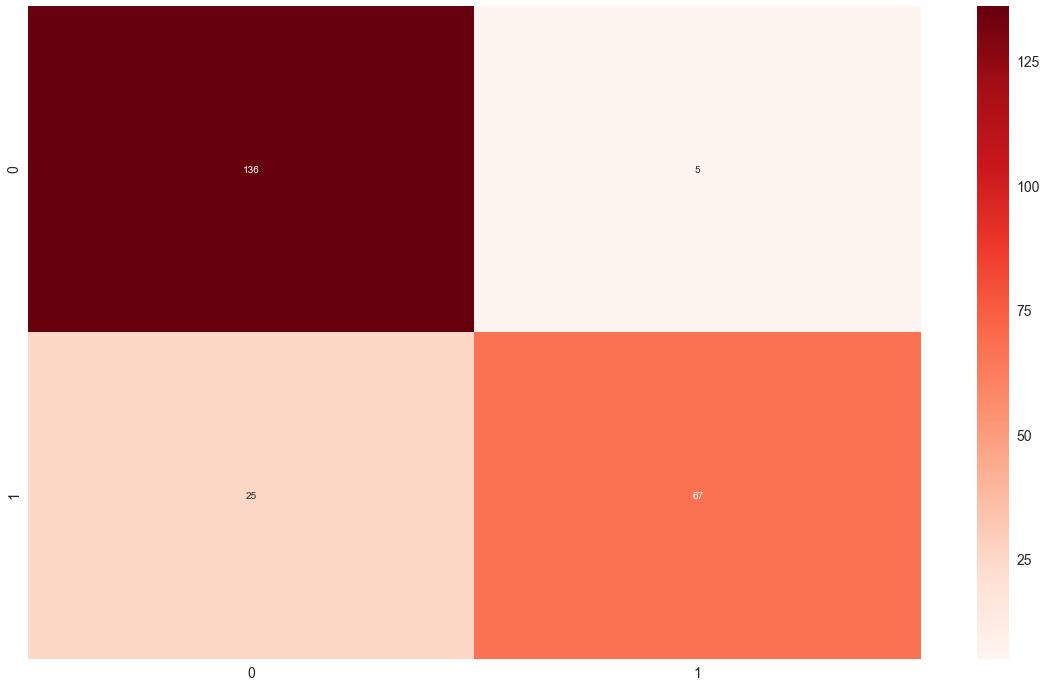

In [53]:
y_pred = knn_gs.best_estimator_.predict(X_reduce_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Accuracy',accuracy_score(y_test, y_pred))
print('Recall',recall_score(y_test, y_pred))
print('F1 Score',f1_score(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
sns.heatmap(confusion, annot=True,annot_kws={"size": 10},fmt='g',cmap='Reds')

### Logit

In [54]:
logit = LogisticRegression()
param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

logit_gs = GridSearchCV(logit, param_grid, cv=5, scoring='recall')
logit_gs.fit(X_reduce_train, y_train)

print(logit_gs.best_params_)
print(logit_gs.best_score_)


{'C': 1000}
0.9764566240218303


[[63 78]
 [34 58]]
             precision    recall  f1-score   support

          0       0.65      0.45      0.53       141
          1       0.43      0.63      0.51        92

avg / total       0.56      0.52      0.52       233

Accuracy 0.51931330472103
Recall 0.6304347826086957
F1 Score 0.5087719298245614


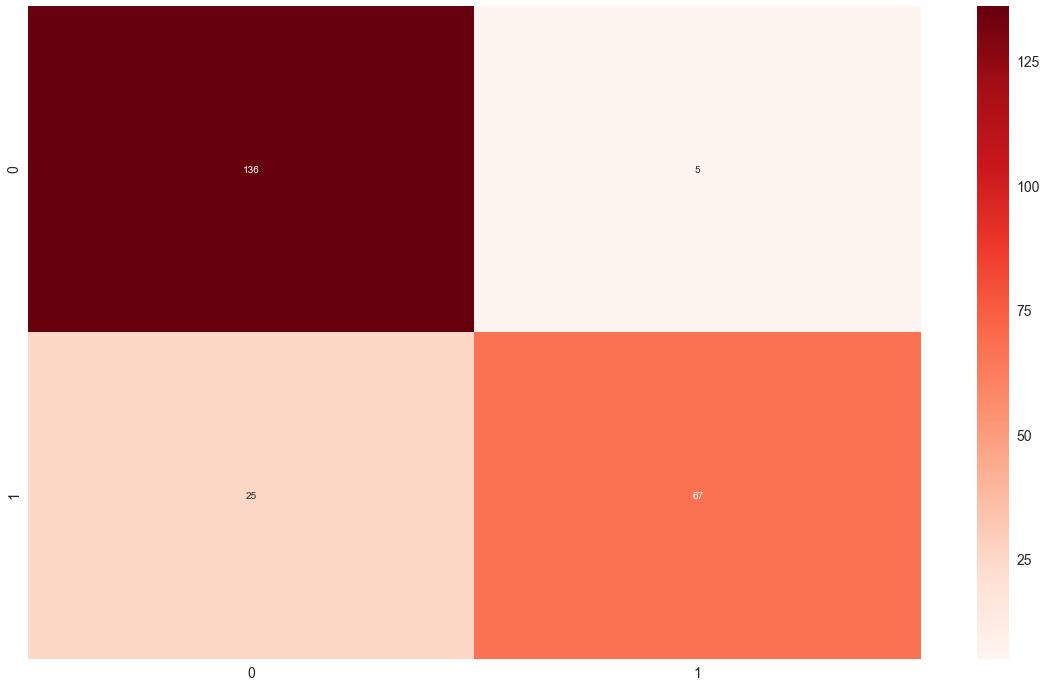

In [55]:
y_pred = logit_gs.best_estimator_.predict(X_reduce_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Accuracy',accuracy_score(y_test, y_pred))
print('Recall',recall_score(y_test, y_pred))
print('F1 Score',f1_score(y_test, y_pred))

onfusion = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
sns.heatmap(confusion, annot=True,annot_kws={"size": 10},fmt='g',cmap='Reds')

### SVM

In [56]:
C = [0.1, 0.5, 1, 5, 10, 50]
param_grid = [
     {'C': C, 'kernel': ['linear']},
     {'C': C, 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
]

score_metric = 'recall'
clf = GridSearchCV(svm.SVC(), param_grid, cv = 5, scoring = score_metric)
clf.fit(X_reduce_train, y_train)
print("Best parameters set found :", clf.best_params_)
print("Best Recall Score", clf.best_score_)

Best parameters set found : {'C': 50, 'kernel': 'linear'}
Best Recall Score 0.9671873374815684


[[74 67]
 [33 59]]
             precision    recall  f1-score   support

          0       0.69      0.52      0.60       141
          1       0.47      0.64      0.54        92

avg / total       0.60      0.57      0.57       233

Accuracy 0.5708154506437768
Recall 0.6413043478260869
F1 Score 0.5412844036697247


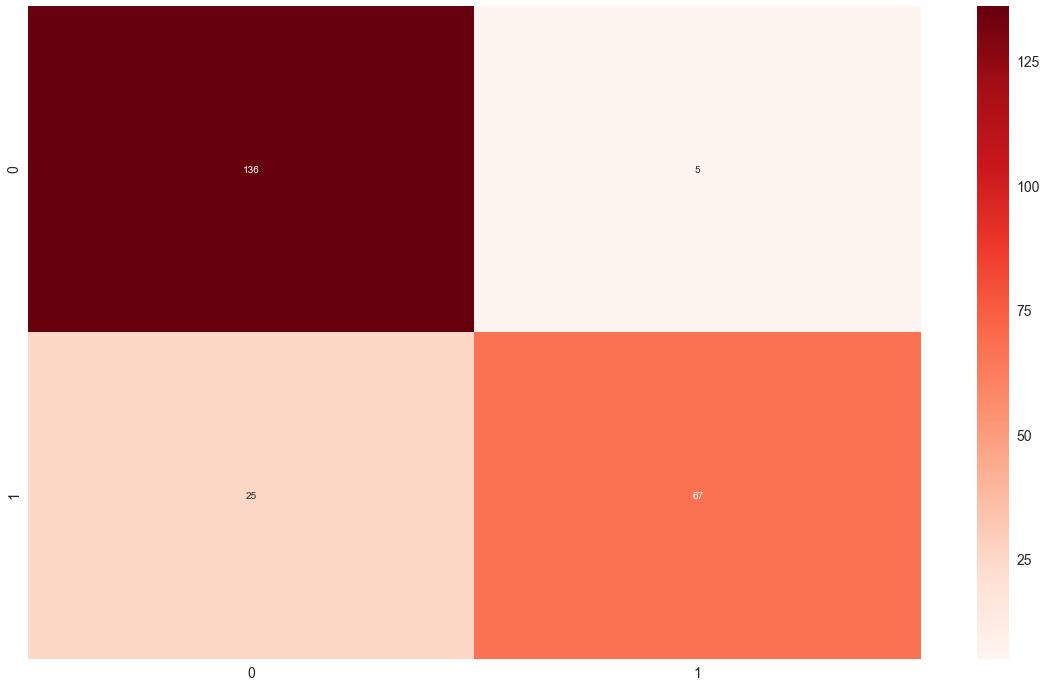

In [57]:
y_pred = clf.best_estimator_.predict(X_reduce_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Accuracy',accuracy_score(y_test, y_pred))
print('Recall',recall_score(y_test, y_pred))
print('F1 Score',f1_score(y_test, y_pred))

onfusion = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
sns.heatmap(confusion, annot=True,annot_kws={"size": 10},fmt='g',cmap='Reds')

### Decision Tree

In [58]:
dtree = DecisionTreeClassifier()

dtree_gs = GridSearchCV(dtree, {}, cv=5, scoring='recall')
dtree_gs.fit(X_reduce_train, y_train)

print(dtree_gs.best_score_)

0.9391102708589538


[[106  35]
 [ 13  79]]
             precision    recall  f1-score   support

          0       0.89      0.75      0.82       141
          1       0.69      0.86      0.77        92

avg / total       0.81      0.79      0.80       233

Accuracy 0.7939914163090128
Recall 0.8586956521739131
F1 Score 0.7669902912621358


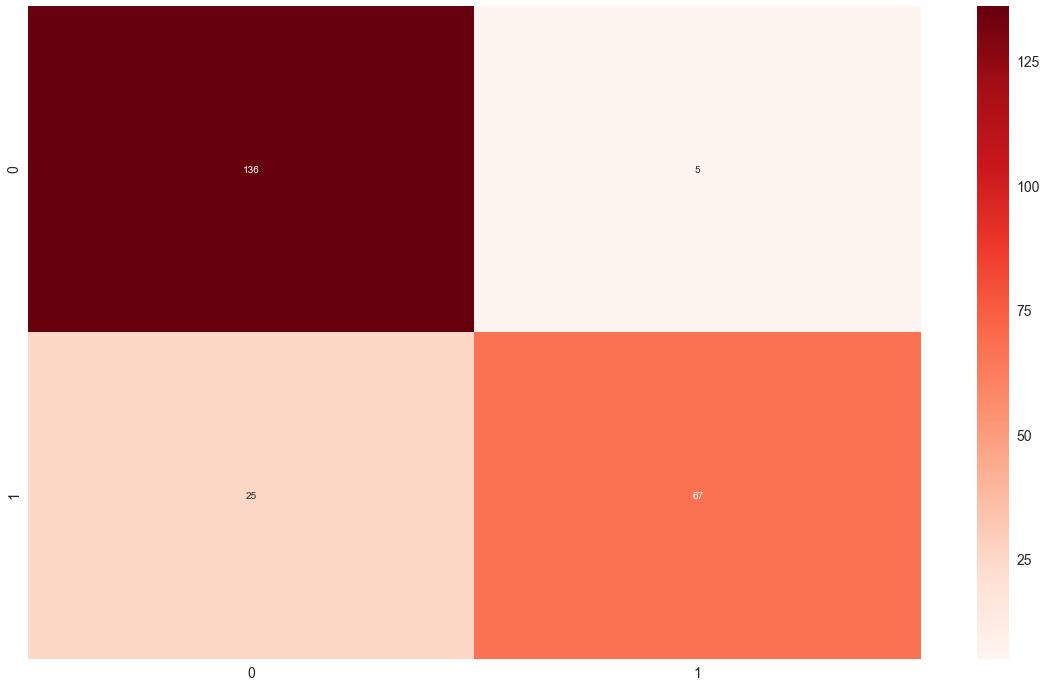

In [59]:
y_pred = dtree_gs.best_estimator_.predict(X_reduce_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Accuracy',accuracy_score(y_test, y_pred))
print('Recall',recall_score(y_test, y_pred))
print('F1 Score',f1_score(y_test, y_pred))

onfusion = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
sns.heatmap(confusion, annot=True,annot_kws={"size": 10},fmt='g',cmap='Reds')

### Comparing Classification Models with and without PCA
As we can see PCA doesn't necessarily help in getting better results, compared to the manual feature selection we performed. But the scores of with and without PCA are comparable, indicating PCA does a good job in eleminating highly correlated features. Since manual feature selection is not possible for large datasets, PCA provides a viable alternate


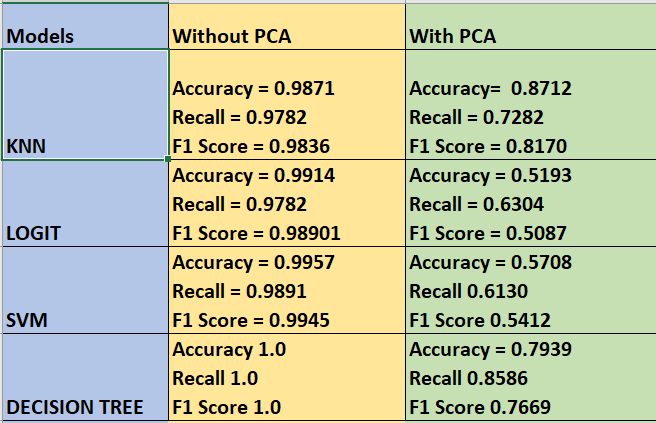

## Deep Learning Model

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### Input layer
ReLu is nonlinear in nature,and combinations of ReLu are also non linear. ReLu also allows for sparse and efficient activations

### Hidden Layer
We add a hidden layer which helps the Neural network converge faster and generalize better

### Output layer
We use the sigmoid activation function since it is always going to be in range (0,1) compared to (-inf, inf) of linear function. So we have our activations bound in a range and it won’t blow up the activations then.

In [57]:
model = Sequential()
#input layer
model.add(Dense(16,input_dim=2, activation='relu'))
#hidden layer
model.add(Dense(8,activation='relu'))
#output layer
model.add(Dense(1,activation='sigmoid'))

#Compile model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

#Fit the model
model.fit(X_train,y_train, epochs=150,batch_size=10)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/150
543/543 [==============================] - 0s 468us/sample - loss: 0.6159 - acc: 0.7716
Epoch 2/150
543/543 [==============================] - 0s 107us/sample - loss: 0.5347 - acc: 0.9669
Epoch 3/150
543/543 [==============================] - 0s 103us/sample - loss: 0.4473 - acc: 0.9613
Epoch 4/150
543/543 [==============================] - 0s 99us/sample - loss: 0.3523 - acc: 0.9595
Epoch 5/150
543/543 [==============================] - 0s 103us/sample - loss: 0.2671 - acc: 0.9595
Epoch 6/150
543/543 [==============================] - 0s 99us/sample - loss: 0.2073 - acc: 0.9540
Epoch 7/150
543/543 [==============================] - 0s 101us/sample - loss: 0.1692 - acc: 0.9558
Epoch 8/150
543/543 [==============================] - 0s 101us/sample - loss: 0.1462 - acc: 0.9558
Epoch 9/150
543/543 [==============================] - 0s 110us/sample - loss: 0.1

In [58]:
#Evaluate Model
scores= model.evaluate(X_test,y_test)

233/233 [==============================] - 0s 244us/sample - loss: 0.1081 - acc: 0.9571


In [60]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_train)
print("R2 value: %.2f" % r2_score(y_test, model.predict(X_test)))

R2 value: 0.86


Thus the model is able to account for 86% of the variation